## Import libraries:

In [66]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Load Data:

data=pd.read_csv("Reviews.csv",nrows=5000)
data.drop_duplicates(subset=['Text'],inplace=True) #dropping duplicates
data.dropna(axis=0,inplace=True) #dropping na

In [68]:
data.head(n=2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4984 entries, 0 to 4999
Data columns (total 10 columns):
Id                        4984 non-null int64
ProductId                 4984 non-null object
UserId                    4984 non-null object
ProfileName               4984 non-null object
HelpfulnessNumerator      4984 non-null int64
HelpfulnessDenominator    4984 non-null int64
Score                     4984 non-null int64
Time                      4984 non-null int64
Summary                   4984 non-null object
Text                      4984 non-null object
dtypes: int64(5), object(5)
memory usage: 428.3+ KB


## Preprocessing:

In [70]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
 "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
 "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
 "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
 "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
 "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
 "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
 "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
 "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
 "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
 "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
 "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
 "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
 "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
 "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
 "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
 "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
 "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
 "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
 "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
 "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
 "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
 "you're": "you are", "you've": "you have"}

In [71]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1: #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [72]:
cleaned_text = []
for t in data['Text']:
 cleaned_text.append(text_cleaner(t,0))

cleaned_summary = []
for t in data['Summary']:
 cleaned_summary.append(text_cleaner(t,1))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [73]:
data.head(n=2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised


In [74]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [75]:
cleaned_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

## Understanding the distribution of the sequences:

Analyze the length of the reviews and the summary to get an overall idea about the
distribution of length of the text

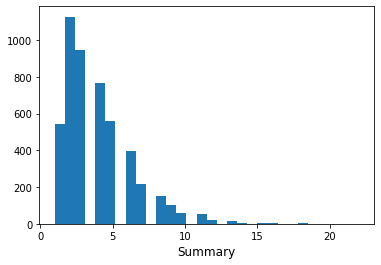

In [76]:
#https://stackoverflow.com/questions/22880817/make-histogram-in-python-with-list
#https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
import matplotlib.pyplot as plt

sum_len = []

for i in data['cleaned_summary']:
    sum_len.append(len(i.split()))
    
plt.xlabel('Summary',fontsize = 12)
plt.hist(sum_len,bins = 30)
plt.show()

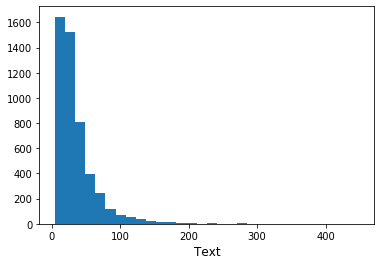

In [77]:
text_len = []

for i in data['cleaned_text']:
    text_len.append(len(i.split()))
    
plt.xlabel('Text',fontsize = 12)
plt.hist(text_len,bins = 30)
plt.show()

Get the proportion of the length of summaries below 6,8 and 10

In [78]:
count_6 = 0 
for i in data['cleaned_summary']:
    if len(i.split()) <= 6:
        count_6 += 1
print(count_6/len(data['cleaned_summary']))

0.8711102188315599


In [79]:
count_8 = 0
for i in data['cleaned_summary']:
    if len(i.split()) <=8:
        count_8 +=1
print(count_8/len(data['cleaned_summary']))

0.9451917285685605


In [80]:
count_10 = 0
for i in data['cleaned_summary']:
    if len(i.split()) <=10:
        count_10 +=1
print(count_10/len(data['cleaned_summary']))

0.9775145553101787


In [81]:
max_text_len=50
max_summary_len=10

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary']) 

short_text=[]
short_summary=[] 

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i]) 

df=pd.DataFrame({'text':short_text,'summary':short_summary})
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

## Data split: 

In [82]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

## Build the tokenizer for both the text and summary:

In [83]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr, maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val, maxlen=max_text_len, padding='post')
x_voc_size = len(x_tokenizer.word_index) +1

#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_summary_len, padding='post')
y_voc_size = len(y_tokenizer.word_index) +1

## Model building:

In [84]:
from keras import backend as K
K.clear_session()
latent_dim = 500 

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2
encoder_lstm2=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_output2, state_h2, state_c2= encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

In [85]:
# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

In [86]:
from attention import AttentionLayer

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 500)      6068500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [87]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') 

In [88]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [48]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,
1:] ,epochs=20,callbacks=[es],batch_size=96, validation_data=([x_val,y_val[:,:-1]],
y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 4482 samples, validate on 499 samples
Epoch 1/20
4482/4482 [==============================] - 314s 70ms/sample - loss: 3.5354 - val_loss: 2.4936
Epoch 2/20
4482/4482 [==============================] - 562s 125ms/sample - loss: 2.8490 - val_loss: 2.3921
Epoch 3/20
4482/4482 [==============================] - 332s 74ms/sample - loss: 2.7160 - val_loss: 2.4065
Epoch 4/20
4482/4482 [==============================] - 355s 79ms/sample - loss: 2.6161 - val_loss: 2.3615
Epoch 5/20
4482/4482 [==============================] - 374s 83ms/sample - loss: 2.5195 - val_loss: 2.3285
Epoch 6/20
4482/4482 [==============================] - 364s 81ms/sample - loss: 2.4132 - val_loss: 2.3191
Epoch 7/20
4482/4482 [==============================] - 349s 78ms/sample - loss: 2.3082 - val_loss: 2.2922
Epoch 8/20
4482/4482 [==============================] - 331s 74ms/sample - loss: 2.1967 - val_loss: 2.2936
Epoch 9/20
4482/4482 [==============================] - 333s 74ms/sample - loss: 2.0865 - val_lo

## Diagnostic plot

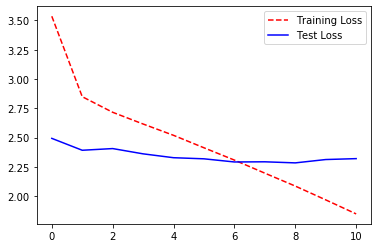

In [89]:
#https://chrisalbon.com/deep_learning/keras/visualize_loss_history/
training_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(training_loss, 'r--')
plt.plot(test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.show()

## Inference

In [90]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [91]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [92]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary_len-1)):
                stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [93]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [94]:
for i in range(10):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: great product stevia powder raise blood glucose level natural use sparingly since much sweeter sugar tastes natural artifical sweeteners healthy use since organic natural sweetener 
Original summary: white stevia oz 
Predicted summary:  become mae become their yummier yummier superb it flavoring


Review: got family member part football themed gift like basket reused pasta know good know items taste 
Original summary: great for fans who have everything 
Predicted summary:  become mae exciting huge babies alert become changes slickers


Review: using food months find excellent fact two dogs love food thriving coats excellent condition overall perfect good tasting dog good good deal owner around best food ever used excellent 
Original summary: premium quality dog food 
Predicted summary:  become mae spritzer substantial spritzer sea iodine fragrance teething


Review: tried tons different first thing sudafed actually work tried sinus yet moderate congestion works wonders smells b

## Measure performance 

### BLEU score & ROUGE metric

In [95]:
from nltk.translate.bleu_score import sentence_bleu
def bleu_score(reference, candidate):
    score = sentence_bleu(reference,candidate)
    return score

In [96]:
from rouge import Rouge
rouge = Rouge()
rouge_score = []

In [97]:
bleu = []
for i in range(10):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("BLEU score: ", bleu_score(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_text_len))))
    #print("ROUGE:", rouge(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_text_len))))
    print("RougeL", rouge.get_scores(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_text_len))))
    print("\n")
    bleu.append(bleu_score(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_text_len))))
    rouge_score.append(rouge.get_scores(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_text_len))))

Review: great product stevia powder raise blood glucose level natural use sparingly since much sweeter sugar tastes natural artifical sweeteners healthy use since organic natural sweetener 
Original summary: white stevia oz 
Predicted summary:  become mae become their yummier yummier superb it flavoring
BLEU score:  1.1337861261109773e-231
RougeL [{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]


Review: got family member part football themed gift like basket reused pasta know good know items taste 
Original summary: great for fans who have everything 
Predicted summary:  become mae exciting huge babies alert become changes slickers
BLEU score:  1.1823840769073583e-231
RougeL [{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]


Review: using food months find excellent fact two dogs love food thriving coats excellent conditio

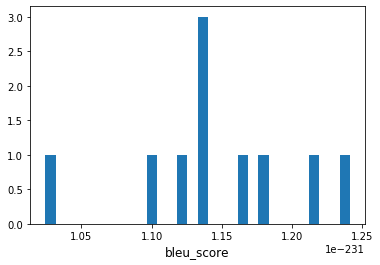

In [98]:
plt.xlabel('bleu_score',fontsize = 12)
plt.hist(bleu,bins = 30)
plt.show()